In [6]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex


# Plots for static objectives

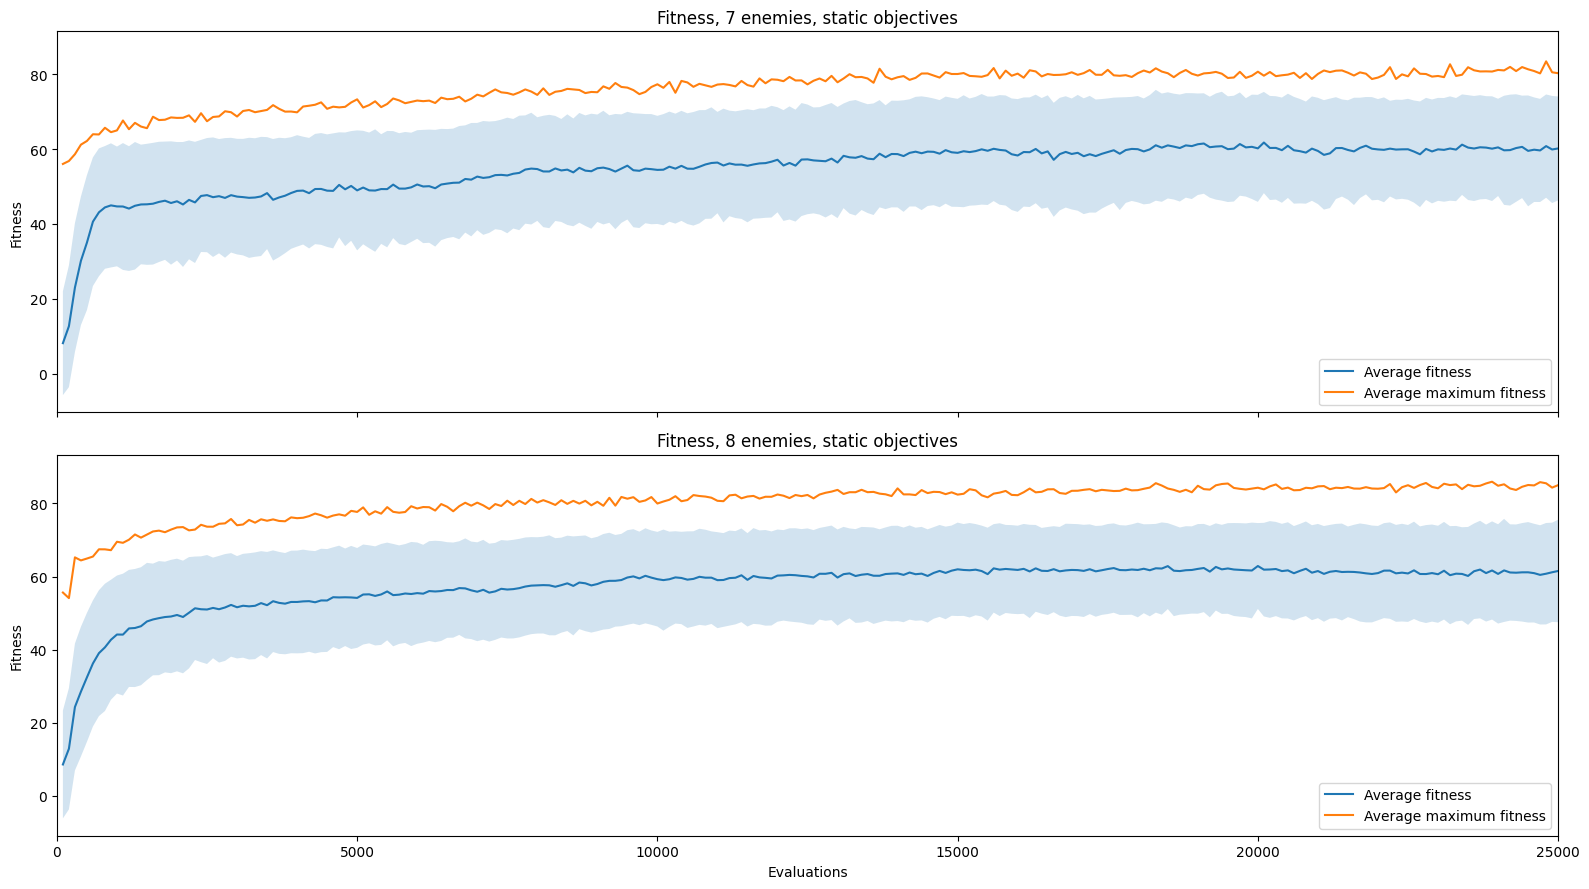

In [4]:
fig, ax = plt.subplots(2, figsize=(16, 9), sharex=True)
for i, n_enemies in enumerate([7, 8]):
    fitness_mean_grouped = []
    fitness_max_grouped = []
    fitness_std_grouped = []
    
    for s in os.listdir(f'plotdata/Static objectives {n_enemies} enemies trained'):
        if s.endswith('.csv'):
            df = pd.read_csv(f'plotdata/Static objectives {n_enemies} enemies trained/{s}')
            f = [f'f{j}' for j in range(1, n_enemies+1)]            
            df['f_mean'] = df[f].mean(axis=1)
            
            fitness_mean = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).mean().reset_index()
            fitness_mean = fitness_mean.set_index('n_evals')['f_mean']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max = fitness_max.set_index('n_evals')['f_mean']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std = fitness_std.set_index('n_evals')['f_mean']
            fitness_std_grouped.append(fitness_std)

    fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_evals').mean()
    fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_evals').mean()
    fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_evals').mean()
    
    # Plot average and max
    sns.lineplot(fitness_mean_agg,
                ax=ax[i], label='Average fitness')
    sns.lineplot(fitness_max_agg,
                ax=ax[i], label='Average maximum fitness')

    ax[i].fill_between(fitness_mean_agg.index, 
                        fitness_mean_agg - fitness_std_agg, 
                        fitness_mean_agg + fitness_std_agg, 
                        alpha=0.2)


    # Plot legend
    ax[i].set_title(f'Fitness, {n_enemies} enemies, static objectives')
    ax[i].set_xlim(0, 25_000)
    ax[i].legend(loc=4)
    ax[i].set_xlabel('Evaluations')
    ax[i].set_ylabel('Fitness')


# Show
fig.tight_layout()
plt.show();

# Plots for dynamic objectives

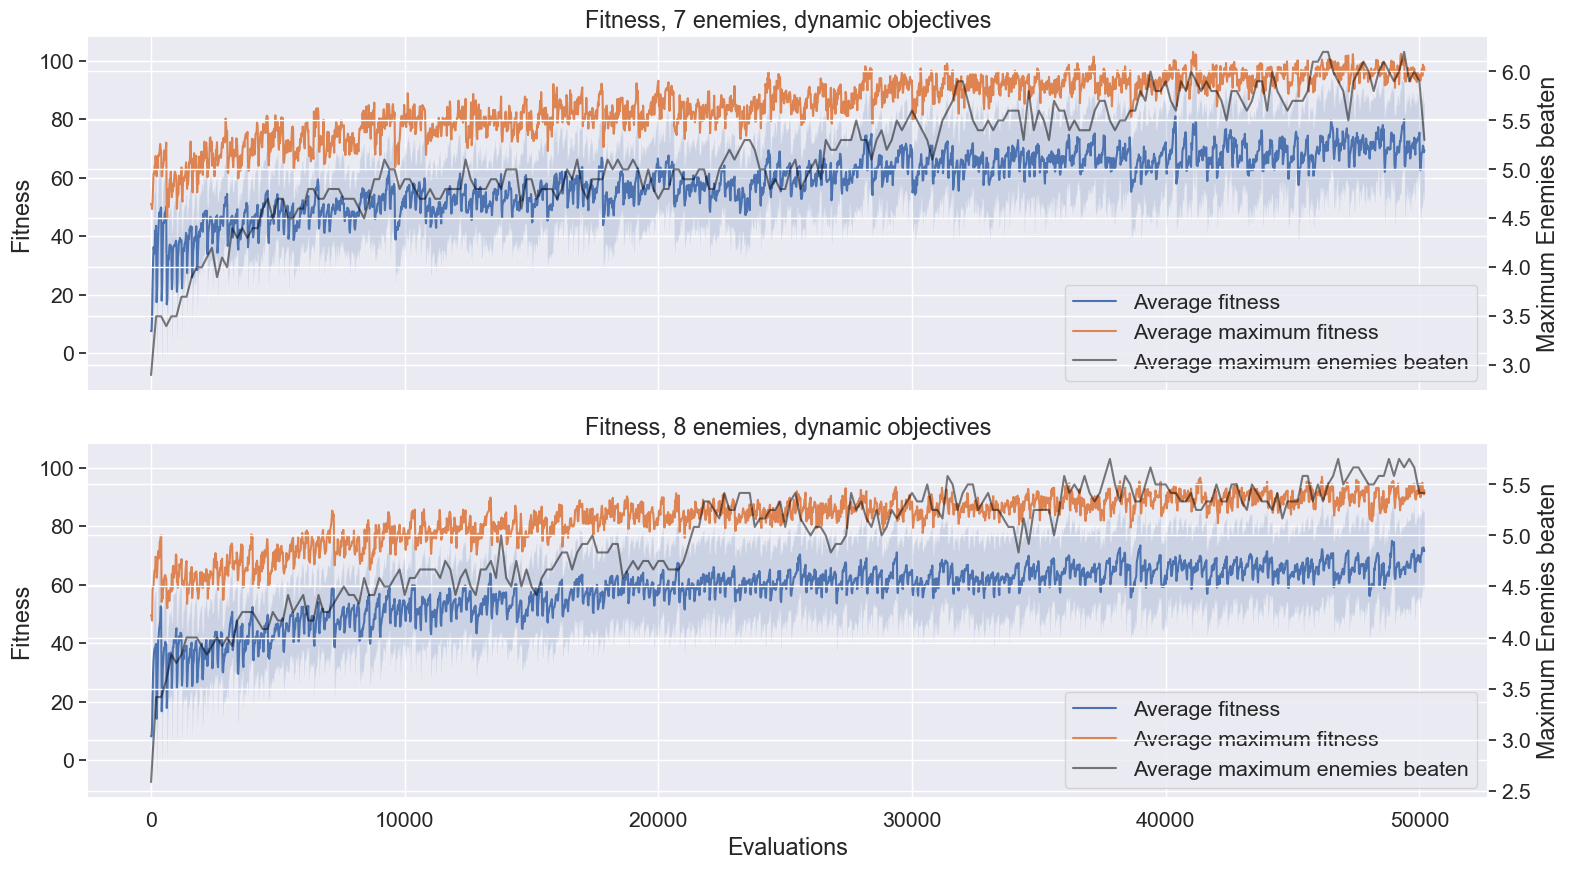

In [25]:
fig, ax = plt.subplots(2, figsize=(16, 9), sharex=True, sharey=True)

for idx, n_enemies in enumerate([7, 8]):
    # Get fitness values for either 7 or 8 enemy objective
    fitness_mean_grouped = []
    fitness_max_grouped = []
    fitness_std_grouped = []

    for f in os.listdir(f'plotdata/Dynamic objectives {n_enemies}'):
        if f.endswith('.csv') and f.startswith('dynamic_objectives') and 'secondary' not in f and not f.startswith('dynamic_objectives_5'):
            df = pd.read_csv(f'plotdata/Dynamic objectives {n_enemies}/{f}')
            
            fitness_mean = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).mean().reset_index()
            fitness_mean['n_eval'] = 200 * fitness_mean['n_iter'] + 20 * fitness_mean['n_gens']
            fitness_mean = fitness_mean.set_index('n_eval')['mean_obj']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max['n_eval'] = 200 * fitness_max['n_iter'] + 20 * fitness_max['n_gens']
            fitness_max = fitness_max.set_index('n_eval')['max_obj']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std['n_eval'] = 200 * fitness_std['n_iter'] + 20 * fitness_std['n_gens']
            fitness_std = fitness_std.set_index('n_eval')['std_obj']
            fitness_std_grouped.append(fitness_std)

    fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_eval').mean()
    fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_eval').mean()
    fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_eval').mean()
    
    # Get max beaten value for either 7 or 8 objective
    max_beaten = []
    for f in os.listdir(f'plotdata/Dynamic objectives {n_enemies}'):
        if f.endswith('.csv') and f.startswith('max'):
            df = pd.read_csv(f'plotdata/Dynamic objectives {n_enemies}/{f}')
            for i in range(df.shape[0]):
                # Handle first two values
                if i == 0:
                    pass
                elif i == 1:
                    df.iloc[i, 0:2] = [1, 200]
                # Handle double values
                if df.iloc[i, 1] == df.iloc[i-1, 1]:
                    df.iloc[i, 0] += 1
                    df.iloc[i, 1] += 200
            
            max_beaten.append(df)

    max_beaten = pd.concat(max_beaten).reset_index(drop=True)

    # Plot average and max for objective
    sns.lineplot(fitness_mean_agg,
                ax=ax[idx], label='Average fitness')
    sns.lineplot(fitness_max_agg,
                ax=ax[idx], label='Average maximum fitness')

    ax[idx].fill_between(fitness_mean_agg.index, 
                    fitness_mean_agg - fitness_std_agg, 
                    fitness_mean_agg + fitness_std_agg, 
                    alpha=0.2)

    # Plot max enemies beaten for objective
    ax2 = ax[idx].twinx()
    sns.lineplot(data=max_beaten, x='n_evals', y='max_enemies_beaten',
                ax=ax2, label='Average maximum enemies beaten', legend=None,
                color='black', errorbar=None, alpha=0.5)

    # Plot legend
    lines, labels = ax[idx].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax[idx].legend(lines+lines2, labels+labels2, loc=4)
    ax[idx].set_title(f'Fitness, {n_enemies} enemies, dynamic objectives')
    ax[idx].set_xlabel('Evaluations')
    ax[idx].set_ylabel('Fitness')
    ax2.set_ylabel('Maximum Enemies beaten')

# Show
fig.tight_layout()
plt.show();    

# Combined plots for Dynamic and Static

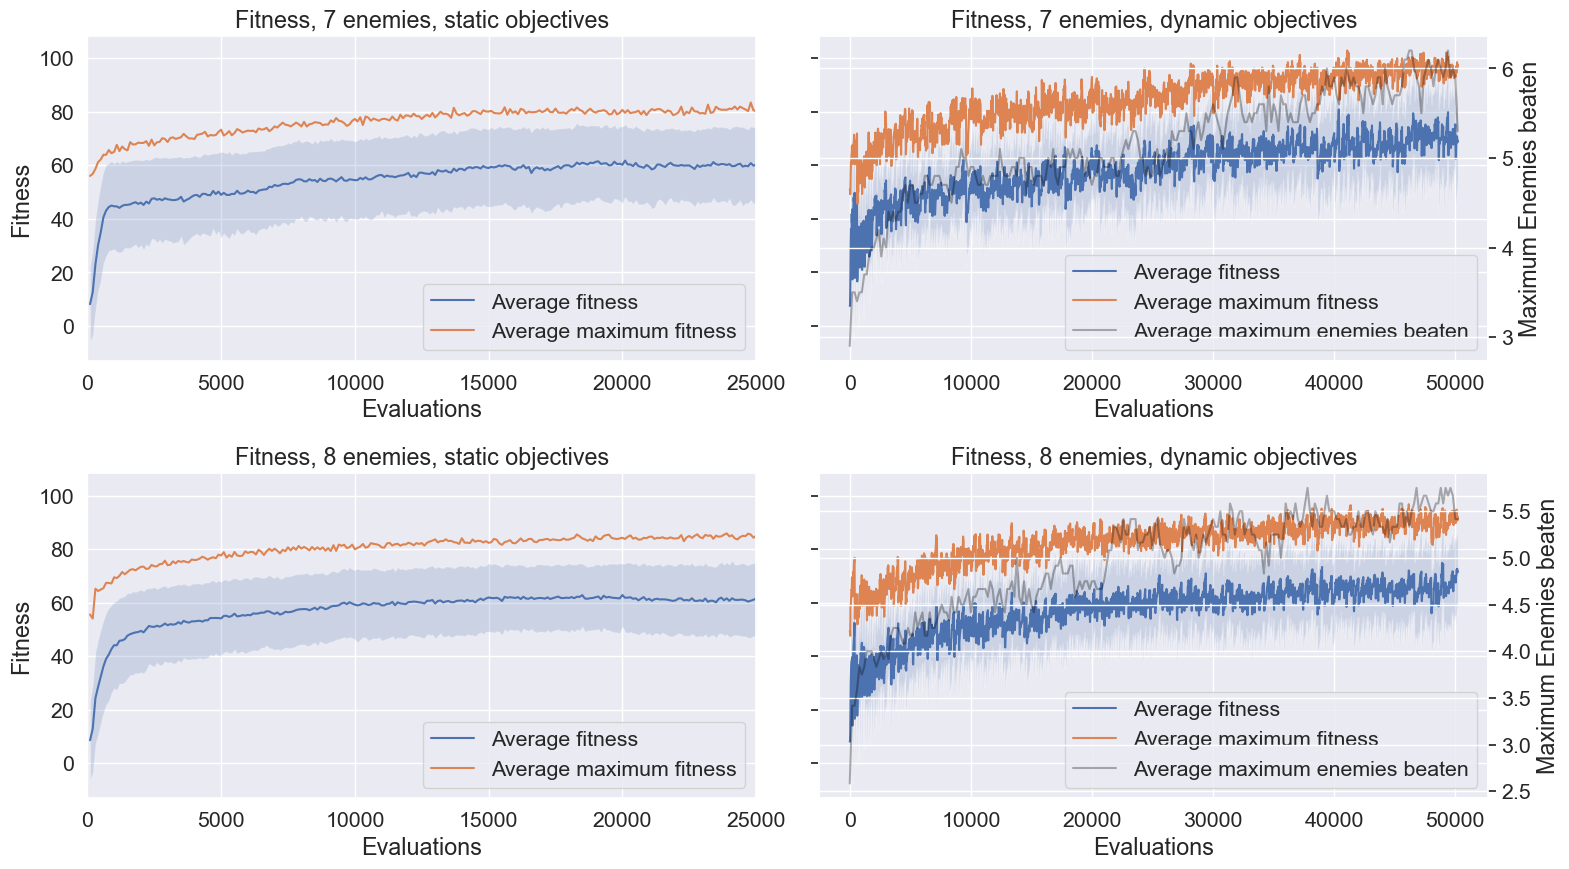

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
# sns.set_theme(style='white')
sns.set_style("whitegrid")
sns.set(font_scale=1.4)
# Static objectives
for i, n_enemies in enumerate([7, 8]):
    fitness_mean_grouped = []
    fitness_max_grouped = []
    fitness_std_grouped = []
    
    for s in os.listdir(f'plotdata/Static objectives {n_enemies} enemies trained'):
        if s.endswith('.csv'):
            df = pd.read_csv(f'plotdata/Static objectives {n_enemies} enemies trained/{s}')
            f = [f'f{j}' for j in range(1, n_enemies+1)]            
            df['f_mean'] = df[f].mean(axis=1)
            
            fitness_mean = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).mean().reset_index()
            fitness_mean = fitness_mean.set_index('n_evals')['f_mean']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max = fitness_max.set_index('n_evals')['f_mean']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_evals', 'n_gens', 'f_mean']].groupby(['n_evals', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std = fitness_std.set_index('n_evals')['f_mean']
            fitness_std_grouped.append(fitness_std)

    fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_evals').mean()
    fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_evals').mean()
    fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_evals').mean()
    
    # Plot average and max
    sns.lineplot(fitness_mean_agg,
                ax=ax[i, 0], label='Average fitness')
    sns.lineplot(fitness_max_agg,
                ax=ax[i, 0], label='Average maximum fitness')

    ax[i, 0].fill_between(fitness_mean_agg.index, 
                        fitness_mean_agg - fitness_std_agg, 
                        fitness_mean_agg + fitness_std_agg, 
                        alpha=0.2)


    # Plot legend
    ax[i, 0].set_title(f'Fitness, {n_enemies} enemies, static objectives')
    ax[i, 0].set_xlim(0, 25_000)
    ax[i, 0].legend(loc=4)
    ax[i, 0].set_xlabel('Evaluations')
    ax[i, 0].set_ylabel('Fitness')

for idx, n_enemies in enumerate([7, 8]):
    # Get fitness values for either 7 or 8 enemy objective
    fitness_mean_grouped = []
    fitness_max_grouped = []
    fitness_std_grouped = []

    for f in os.listdir(f'plotdata/Dynamic objectives {n_enemies}'):
        if f.endswith('.csv') and f.startswith('dynamic_objectives') and 'secondary' not in f and not f.startswith('dynamic_objectives_5'):
            df = pd.read_csv(f'plotdata/Dynamic objectives {n_enemies}/{f}')
            
            fitness_mean = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).mean().reset_index()
            fitness_mean['n_eval'] = 200 * fitness_mean['n_iter'] + 20 * fitness_mean['n_gens']
            fitness_mean = fitness_mean.set_index('n_eval')['mean_obj']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max['n_eval'] = 200 * fitness_max['n_iter'] + 20 * fitness_max['n_gens']
            fitness_max = fitness_max.set_index('n_eval')['max_obj']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std['n_eval'] = 200 * fitness_std['n_iter'] + 20 * fitness_std['n_gens']
            fitness_std = fitness_std.set_index('n_eval')['std_obj']
            fitness_std_grouped.append(fitness_std)

    fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_eval').mean()
    fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_eval').mean()
    fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_eval').mean()
    
    # Get max beaten value for either 7 or 8 objective
    max_beaten = []
    for f in os.listdir(f'plotdata/Dynamic objectives {n_enemies}'):
        if f.endswith('.csv') and f.startswith('max'):
            df = pd.read_csv(f'plotdata/Dynamic objectives {n_enemies}/{f}')
            for i in range(df.shape[0]):
                # Handle first two values
                if i == 0:
                    pass
                elif i == 1:
                    df.iloc[i, 0:2] = [1, 200]
                # Handle double values
                if df.iloc[i, 1] == df.iloc[i-1, 1]:
                    df.iloc[i, 0] += 1
                    df.iloc[i, 1] += 200
            
            max_beaten.append(df)

    max_beaten = pd.concat(max_beaten).reset_index(drop=True)

    # Plot average and max for objective
    sns.lineplot(fitness_mean_agg,
                ax=ax[idx,1], label='Average fitness')
    sns.lineplot(fitness_max_agg,
                ax=ax[idx,1], label='Average maximum fitness')

    
    ax[idx,1].fill_between(fitness_mean_agg.index, 
                    fitness_mean_agg - fitness_std_agg, 
                    fitness_mean_agg + fitness_std_agg, 
                    alpha=0.2)

    # Plot max enemies beaten for objective
    ax2 = ax[idx,1].twinx()
    sns.lineplot(data=max_beaten, x='n_evals', y='max_enemies_beaten',
                ax=ax2, label='Average maximum enemies beaten', legend=None,
                color='black', errorbar=None, alpha=0.3)

    # Plot legend
    lines, labels = ax[idx,1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax[idx,1].legend(lines+lines2, labels+labels2, loc=4)
    ax[idx,1].set_title(f'Fitness, {n_enemies} enemies, dynamic objectives')
    ax[idx,1].set_xlabel('Evaluations')
    ax[idx,1].set_ylabel('Fitness')
    ax2.set_ylabel('Maximum Enemies beaten')

# Show
fig.tight_layout()
plt.show();    

# Boxplots

In [4]:
import numpy as np
import pandas as pd
import ast
import os

algorithm_gain = []

## Have to import random search separately as it needs to be parsed first
batch_gain = []
random_solutions = []
for f in os.listdir('plotdata/boxplotdata/random_search_performance_generalist'):
    data = pd.read_csv(f'plotdata/boxplotdata/random_search_performance_generalist/{f}', index_col=0)
    random_solutions.append(data)
    
random_solutions = pd.concat(random_solutions)
# Group in batches of 50 000 (SLOW)
for k, g in random_solutions.groupby(np.arange(len(random_solutions))//50000):
    data = g.copy()
    
    # Lists in dataframe are stored as string, so first convert back to list
    data['enemy lives'] = data['enemy lives'].apply(lambda x: ast.literal_eval(x))
    data['player lives'] = data['player lives'].apply(lambda x: ast.literal_eval(x))
    
    # Make NP array of lists for substraction
    en = data['enemy lives'].map(np.array)
    pl = data['player lives'].map(np.array)
    # data[['enemy lives', 'player lives']]
    data['individual gain'] = en - pl
    data['individual gain'] = data['individual gain'].apply(lambda x: sum(x))
    
    # Get the best performing solution per batch
    best_batch_gain = data[data['enemies beaten'] == data['enemies beaten'].max()].nlargest(1, 'individual gain')
    batch_gain.append(best_batch_gain)
    
random = pd.concat(batch_gain)[['enemies beaten', 'individual gain']].rename(columns={'enemies beaten': 'enemies_beaten', 'individual gain': 'ind_gain'})
random['file'] = 'random_search'
algorithm_gain.append(random)

# Afterwards, load in the rest
for f in os.listdir('plotdata/boxplotdata/'):
    if f.endswith('csv'):
        data = pd.read_csv(f'plotdata/boxplotdata/{f}', index_col=0)
        
        # Set file name so we can differentiate in the boxplot, can change name later
        data['file'] = f
        algorithm_gain.append(data)
    
algorithm_gain = pd.concat(algorithm_gain).replace({
    'random_search': 'Random-Search',
    'dynamic_7_enemies.csv': 'Dynamic-7',
    'dynamic_8_enemies.csv': 'Dynamic-8',
    'static_7_enemies.csv': 'Static-7',
    'static_8_enemies.csv': 'Static-8',
})
algorithm_gain.head()

,enemies_beaten,ind_gain,file
24024,4,254.8,Random-Search
14841,5,96.2,Random-Search
75974,4,262.8,Random-Search
11042,4,257.4,Random-Search
77594,5,-76.8,Random-Search


/var/folders/88/v5lhf14x1r5bv01kg4dwr5780000gn/T/ipykernel_1470/1290767287.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=algorithm_gain,
/var/folders/88/v5lhf14x1r5bv01kg4dwr5780000gn/T/ipykernel_1470/1290767287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=algorithm_gain,
/var/folders/88/v5lhf14x1r5bv01kg4dwr5780000gn/T/ipykernel_1470/1290767287.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=algorithm_gain,
/var/folders/88/v5lhf14x1r5bv01kg4dwr5780000gn/T/ipykernel_1470/1290767287.py:21: FutureWarning: 


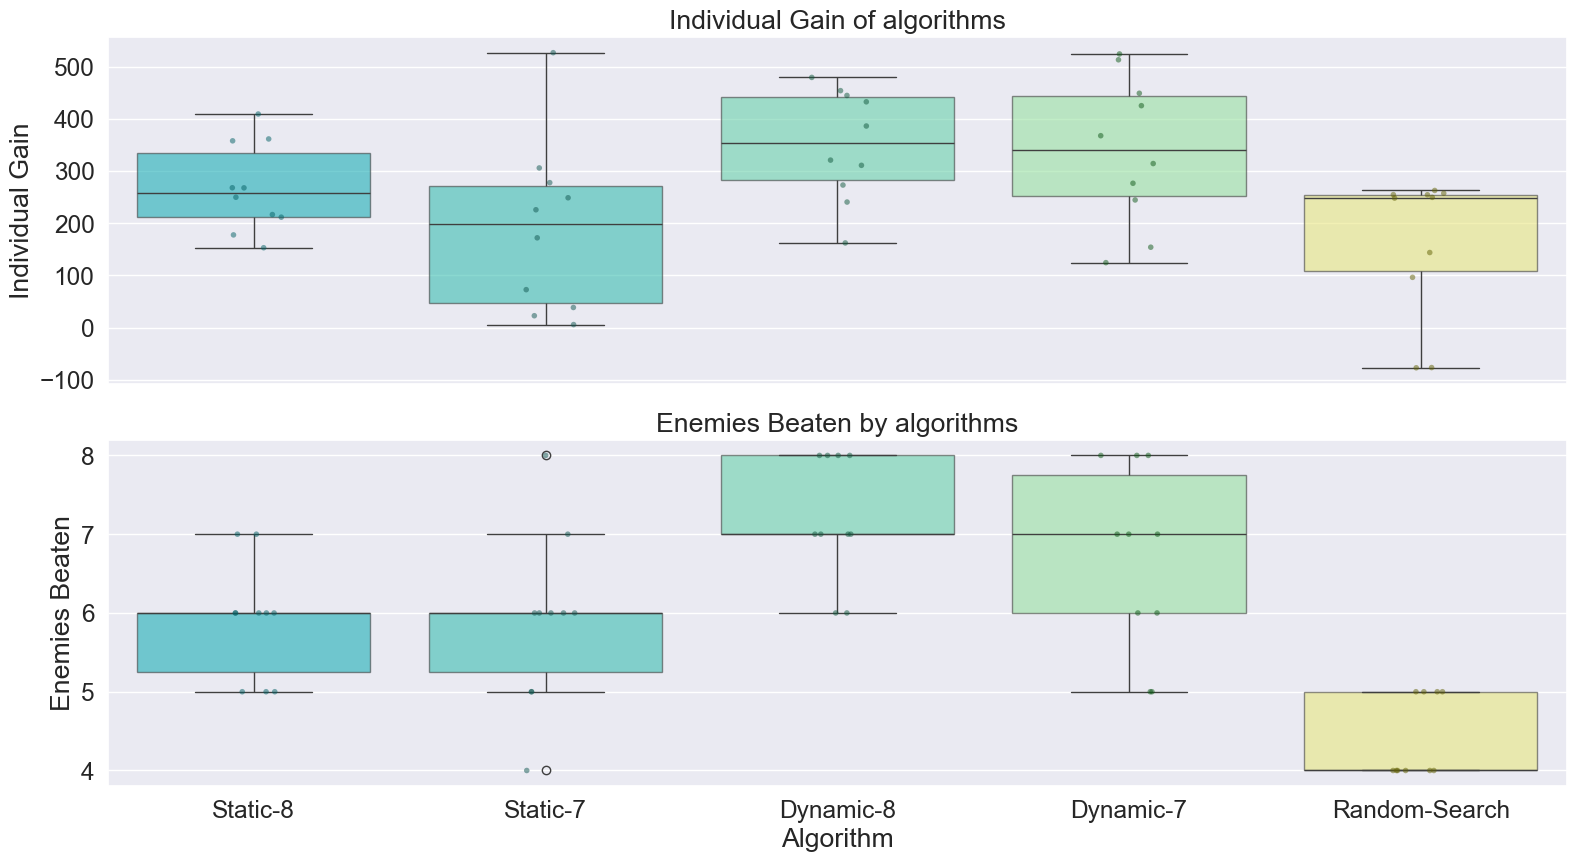

In [16]:
# Title dict
title_dict = {
    'ind_gain': 'Individual Gain',
    'enemies_beaten': 'Enemies Beaten'
}
# Make subplot
fig, ax = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

palette = ['#04C5CF', '#26D4C4', '#5AE2B0', '#8DED99', '#F9F871']
palette_dark = [to_hex(sns.set_hls_values(x, l=0.2)) for x in palette]
order = ['Static-8', 'Static-7', 'Dynamic-8', 'Dynamic-7', 'Random-Search']

# Plot!
for i, k in enumerate(title_dict.keys()):
    sns.set(font_scale=1.6)
    sns.boxplot(data=algorithm_gain, 
                x='file', y=k, ax=ax[i],
                palette=palette, boxprops=dict(alpha=0.6),
                order=order)
    
    sns.stripplot(data=algorithm_gain, 
                x='file', y=k, ax=ax[i],
                palette=palette_dark, alpha=0.5, size=4,
                order=order)

    title = f'{title_dict[k]} of algorithms' if k == 'ind_gain' else f'{title_dict[k]} by algorithms'
    ax[i].set_title(f'{title}')
    ax[i].set_xlabel('Algorithm')
    ax[i].set_ylabel(f'{title_dict[k]}')

# Show!
fig.tight_layout()
plt.show();